# TotalVI Comparisons

Get the r2 prediction using TotalVI counterfactual prediction facility.

Note: use `scvienv` conda environment for this notebook.

In [1]:
import sys
sys.path.append("../../multicpa")

In [2]:
import seaborn as sns
import torch
import pickle
import numpy as np
import pandas as pd
from itertools import compress
import contextlib
import warnings
import os
import scanpy as sc
from sklearn.metrics import r2_score
from MultiCPA.helper import model_importer

In [3]:
import scvi

Global seed set to 0


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [6]:
os.chdir('./../')
os.getcwd()

'/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility'

In [7]:
DATAM = {'papalexi': {'raw_dir_name': 'Papalexi2021', 'adata_name': 'Papalexi21_prep.h5ad', 'seml': 'mpert12',
                    'nt_condition': "THP-1_NT_1.0"},
        'wessel': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_prep.h5ad', 'seml': 'mpert15',
                  'nt_condition': "THP-1_NT_1"},
        'wessel_ood': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_prep.h5ad', 'seml': 'mpert16',
                  'nt_condition': "THP-1_NT_1"},
        'wessel_ood_noprot': {'raw_dir_name': 'Wessel2022', 'adata_name': 'Wessel22_noprot_prep.h5ad', 'seml': 'mpert17',
                  'nt_condition': "THP-1_NT_1"},
        'papalexi_all': {'raw_dir_name': 'Papalexi2021', 'adata_name': 'Papalexi21_prep.h5ad', 'seml': 'mpert18',
                    'nt_condition': "THP-1_NT_1.0"},
       }
dataset = 'wessel_ood'
DATA = DATAM[dataset]

In [8]:
raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))

adata.X = adata.layers['counts'].copy()
adata.obsm["protein_expression"] = adata.obsm["protein_expression_raw"].copy()
del adata.layers['counts']
del adata.obsm["protein_expression_raw"]

adata.obsm['protein_expression'] = pd.DataFrame(adata.obsm['protein_expression'].astype(int), index=adata.obs.index, columns=adata.uns['protein_names'])
adata.X = adata.X.A.astype(int)
de_genes = adata.uns["rank_genes_groups_cov"].copy()
del adata.uns
del adata.var
adata.obs = adata.obs[['cov_drug_dose_name', 'control', 'split']]
adata.obs.columns = ['batch', 'control', 'split']
adata.uns["rank_genes_groups_cov"] = de_genes

In [9]:
torch.cuda.is_available()

False

## Train TotalVI model

In [10]:
if False:
    scvi.model.TOTALVI.setup_anndata(adata, batch_key="batch", protein_expression_obsm_key="protein_expression")
    model = scvi.model.TOTALVI(adata)
    # as the Papalexi split is 0.85 to 0.15
    model.train(train_size=0.75, validation_size = 0.10, max_epochs=480)

    plt.plot(model.history["elbo_train"], label="train")
    plt.plot(model.history["elbo_validation"], label="val")
    plt.title("Negative ELBO over training epochs")
    plt.legend(); plt.show()

    with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_model.pt", 'wb') as f1:
        pickle.dump(model, f1)
    with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_adata.pt", 'wb') as f2:
        pickle.dump(adata, f2)
else:
    with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_model.pt", 'rb') as f1:
        model = pickle.load(f1)
    with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_adata.pt", 'rb') as f2:
        adata_train = pickle.load(f2)

## Load MulPert Model

In [11]:
mulpert_models = pd.read_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/{DATA['seml']}_pickled.pk")
spt = 'test'
focus_metric_1 = f"{spt}_mean_score_genes_last"
focus_metric_2 = f"{spt}_mean_score_proteins_last"

mulpert_models = mulpert_models[(mulpert_models['status'] == 1)]
mulpert_models = mulpert_models[(mulpert_models[focus_metric_1] > 0) & (mulpert_models[focus_metric_2] > 0)]
mulpert_models["overall_best"] = np.sqrt(mulpert_models[focus_metric_1]**2 + mulpert_models[focus_metric_2]**2)

top_top = 5
mulpert_models = mulpert_models.sort_values(by=["overall_best"], ascending=False)[:top_top]
mulpert_models[[f"{'ood'}_mean_score_genes_last", f"{'ood'}_mean_score_genes_de_last", f"{'ood'}_mean_score_proteins_last",
    f"{'training'}_mean_score_genes_last", f"{'test'}_mean_score_genes_de_last", f"{'training'}_mean_score_proteins_last", 
                f"{'test'}_mean_score_genes_last", f"{'test'}_mean_score_genes_de_last", f"{'test'}_mean_score_proteins_last", 
                "overall_best"]]

,ood_mean_score_genes_last,ood_mean_score_genes_de_last,ood_mean_score_proteins_last,training_mean_score_genes_last,test_mean_score_genes_de_last,training_mean_score_proteins_last,test_mean_score_genes_last,test_mean_score_genes_de_last,test_mean_score_proteins_last,overall_best
_id,,,,,,,,,,
12600,0.966469,0.902744,0.987495,0.979036,0.900969,0.992201,0.950628,0.900969,0.989438,1.372108
523,0.958885,0.875930,0.989729,0.974262,0.893977,0.997580,0.946808,0.893977,0.991967,1.371293
146,0.952903,0.869856,0.985075,0.974326,0.892263,0.997993,0.946064,0.892263,0.990685,1.369851
161,0.953077,0.859862,0.992664,0.974665,0.892307,0.997942,0.945947,0.892307,0.988619,1.368277
12609,0.940798,0.820272,0.992355,0.970010,0.887484,0.999067,0.942726,0.887484,0.991082,1.367836


In [12]:
chosen_model = mulpert_models.index[0]
print(chosen_model)

12600


In [14]:
chosen_model_entry = mulpert_models.loc[chosen_model]
cm_autoencoder, cm_datasets, cm_state, cm_history, cm_hypers = \
    model_importer(chosen_model, mulpert_models, 
                   model_dir=f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/_last/", 
                   dataset_relative_to="/home/icb/kemal.inecik/work/codes/multicpa-reproducibility",)
print(cm_hypers['hparams']['adversary_wd'] == mulpert_models.loc[chosen_model]['config.model.model_args.hparams.adversary_wd'])

/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/notebooks/../../multicpa/MultiCPA/data.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  self.drugs = torch.Tensor(drugs)


True


## Baseline Vol 1: Calculate R^2 score

In [15]:
# for debugging etc
def gene_threshold(true_gene_matrix, threshold=np.inf):
    meanss = np.array(true_gene_matrix).mean(0)
    inn = meanss < threshold
    return inn
gene_thr = np.inf # np.inf to deactivate

In [32]:
nt_condition = DATA['nt_condition']
set_test = set(model.test_indices)

true_genes = pd.DataFrame(adata_train.X, index=adata_train.obs.index, columns=adata_train.var.index)
true_proteins = adata_train.obsm['protein_expression'].copy()
scale_factors = np.array(np.sum(true_genes, axis=1)).ravel()
mmm = gene_threshold(adata_train.X, gene_thr)

test_bools = np.array([i in set_test for i in range(len(adata_train))])
NT_cells = (adata_train.obs['batch'] == nt_condition) & test_bools
scale_factors = scale_factors[NT_cells]

r2genes, r2proteins, r2genes_de = [], [], []
perts_tot = []

perts = sorted(np.unique(adata_train.obs["batch"]))
for ind, perturbation in enumerate(perts):
    print(f"{ind + 1}/{len(perts)}", end=' ')
    
    if perturbation != nt_condition:
        ii = adata_train.obs[(adata_train.obs['batch'] == perturbation) & test_bools].index
        
        if len(ii) > 20:
            perts_tot.append(perturbation)
            
            idx_de = adata_train.var.index.isin(adata_train.uns["rank_genes_groups_cov"][perturbation]) & mmm
            
            # get perturbed batch from NT cells
            gene_means, protein_means = model.get_normalized_expression(
                indices=NT_cells, 
                transform_batch=perturbation,
                include_protein_background=True,
                sample_protein_mixing=False,
                return_mean=True,
                scale_protein=False,
            )
            gene_means = (gene_means.T * scale_factors).T
        
            # get true perturbed cells
            ii_p = true_proteins.loc[ii]
            ii_g = true_genes.loc[ii]

            # Get mean value for each gene for a given perturbation
            predicted_genes_mean = gene_means.to_numpy().mean(0)
            predicted_proteins_mean = protein_means.to_numpy().mean(0)
            true_genes_mean = ii_g.to_numpy().mean(0)
            true_proteins_mean = ii_p.to_numpy().mean(0)

            # Calculate r^2 score for both
            r2genes.append(r2_score(true_genes_mean[mmm], predicted_genes_mean[mmm]))
            r2proteins.append(r2_score(true_proteins_mean, predicted_proteins_mean))
            r2genes_de.append(r2_score(true_genes_mean[idx_de], predicted_genes_mean[idx_de]))
            
print(ind)

1/187 INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
2/187 3/187 4/187 5/187 6/187 7/187 8/187 9/187 10/187 11/187 12/187 13/187 14/187 15/187 16/187 17/187 18/187 19/187 20/187 21/187 22/187 23/187 24/187 25/187 26/187 27/187 28/187 29/187 30/187 31/187 32/187 33/187 34/187 35/187 36/187 37/187 38/187 39/187 40/187 41/187 42/187 43/187 44/187 45/187 46/187 47/187 48/187 49/187 50/187 51/187 52/187 53/187 54/187 55/187 56/187 57/187 58/187 59/187 60/187 61/187 62/187 63/187 64/187 65/187 66/187 67/187 68/187 69/187 70/187 71/187 72/187 73/187 74/187 75/187 76/187 77/187 78/187 79/187 80/187 81/187 82/187 83/187 84/187 85/187 86/187 87/187 88/187 89/187 90/187 91/187 92/187 93/187 94/187 95/187 96/187 97/187 98/187 99/187 100/187 101/187 102/187 103/187 104/187 105/187 106/187 107/187 108/187 109/187 110/187 111/187 112/187 113/187 114/187 115/187 116/187 117/187 118/187 119/187 120/187 121/187 122/187 123/187 124/187 125/187 126/187 127/18

In [33]:
dataset = cm_datasets["test_treated"]
genes_control = cm_datasets["test_control"].raw_genes
proteins_control = cm_datasets["test_control"].raw_proteins
num, dim_genes = genes_control.size(0), genes_control.size(1)
dim_proteins = proteins_control.size(1)
assert np.all(cm_datasets["test_control"].var_names == adata.var.index) # for mm consistency
mmm = gene_threshold(adata.X, gene_thr)

mean_score_proteins = []
mean_score_genes = []
mean_score_genes_de = []
perts_mul = []
for pert_category in sorted(np.unique(dataset.pert_categories)):
    de_idx = np.where(dataset.var_names[mmm].isin(np.array(dataset.de_genes[pert_category])))[0]
    idx = np.where(dataset.pert_categories == pert_category)[0]
    
    if len(idx) > 20:
        perts_mul.append(pert_category)
        
        emb_drugs = dataset.drugs[idx][0].view(1, -1).repeat(num, 1).clone()
        emb_cts = dataset.cell_types[idx][0].view(1, -1).repeat(num, 1).clone()

        gene_predictions, protein_predictions = cm_autoencoder.predict(genes_control, emb_drugs, emb_cts, proteins_control)
        gene_predictions = gene_predictions.detach().cpu()
        protein_predictions = protein_predictions.detach().cpu()

        mean_predict_genes = gene_predictions[:, :dim_genes]
        mean_predict_proteins = protein_predictions[:, :dim_proteins]

        y_true_genes = dataset.raw_genes[idx, :].numpy()
        yt_m_genes = y_true_genes.mean(axis=0)
        yp_m_genes = np.array(mean_predict_genes.mean(0))
        mean_score_genes.append(r2_score(yt_m_genes[mmm], yp_m_genes[mmm]))
        mean_score_genes_de.append(r2_score(yt_m_genes[de_idx], yp_m_genes[de_idx]))

        y_true_proteins = dataset.raw_proteins[idx, :].numpy()
        yt_m_proteins = y_true_proteins.mean(axis=0)
        yp_m_proteins = mean_predict_proteins.mean(0)
        mean_score_proteins.append(r2_score(yt_m_proteins, yp_m_proteins))
        
print(ind)

186


In [34]:
perts_mul_filter = [i in perts_tot for i in perts_mul]
perts_tot_filter = [i in perts_mul for i in perts_tot]
perts_mul = list(compress(perts_mul, perts_mul_filter))
perts_tot = list(compress(perts_tot, perts_tot_filter)) 
print(np.array(perts_tot) == np.array(perts_mul))
print(np.all(np.array(perts_tot) == np.array(perts_mul)))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
True


In [35]:
r2genes = list(compress(r2genes, perts_tot_filter)) 
r2genes_de = list(compress(r2genes_de, perts_tot_filter)) 
r2proteins = list(compress(r2proteins, perts_tot_filter)) 
mean_score_genes = list(compress(mean_score_genes, perts_mul_filter))
mean_score_genes_de = list(compress(mean_score_genes_de, perts_mul_filter))
mean_score_proteins = list(compress(mean_score_proteins, perts_mul_filter))

In [36]:
tot_genes = np.mean(r2genes)
tot_genes_de = np.mean(r2genes_de)
tot_proteins = np.mean(r2proteins)

print(tot_genes)
print(tot_genes_de)
print(tot_proteins)

0.9145235719220024
0.8631998480584182
0.9856835318790356


In [37]:
mulp_genes = np.mean(mean_score_genes)
mulp_genes_de = np.mean(mean_score_genes_de)
mulp_proteins = np.mean(mean_score_proteins)

print(mulp_genes)
print(mulp_genes_de)
print(mulp_proteins)

0.9476191554518312
0.8951870651493008
0.984176392172212


In [38]:
if False:
    plt.subplots(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"TotalVI Genes r$^2$ Score\n{perturbation}")
    plt.scatter(true_genes_mean[mmm], predicted_genes_mean[mmm])
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.subplot(1, 2, 2)
    plt.title(f"TotalVI Proteins r$^2$ Score\n{perturbation}")
    plt.scatter(true_proteins_mean, predicted_proteins_mean)
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

    plt.subplots(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"MulPert Genes r$^2$ Score\n{pert_category}")
    plt.scatter(yt_m_genes[mmm], yp_m_genes[mmm])
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.subplot(1, 2, 2)
    plt.title(f"MulPert Proteins r$^2$ Score\n{pert_category}")
    plt.scatter(yt_m_proteins, yp_m_proteins)
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

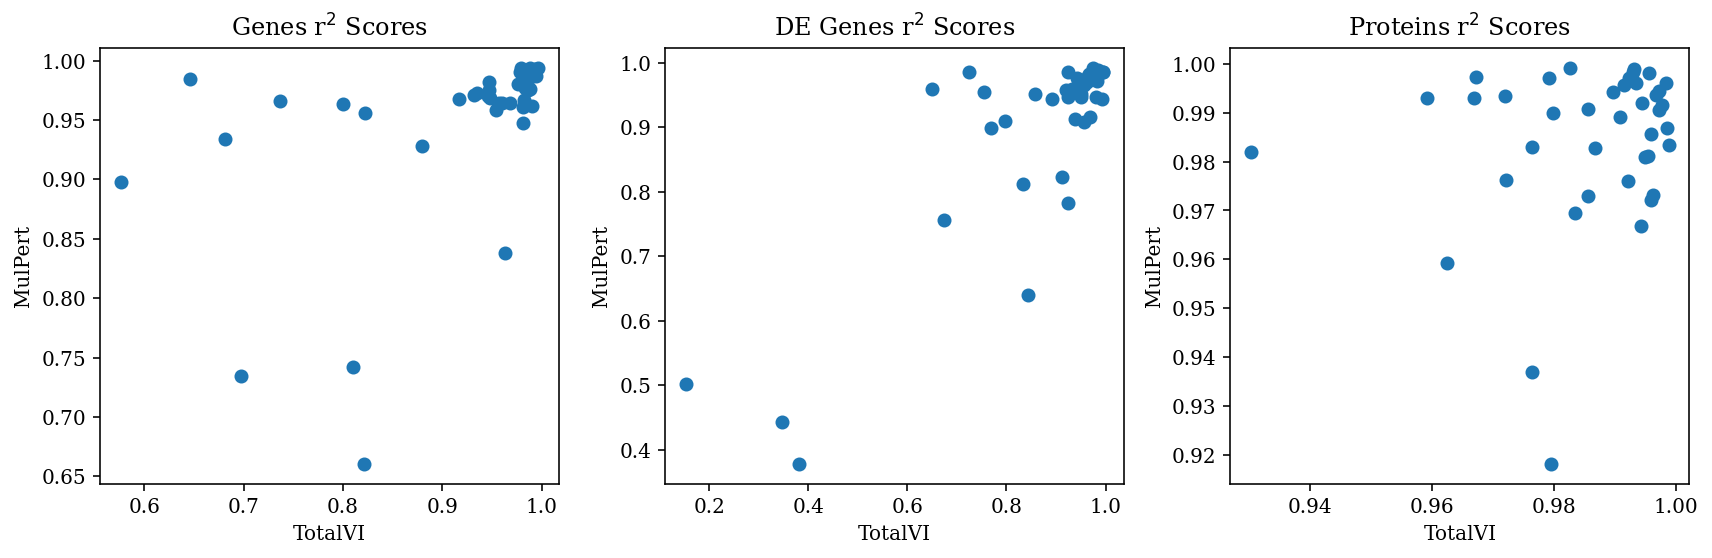

In [39]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title(f"Genes r$^2$ Scores")
plt.scatter(r2genes, mean_score_genes)
plt.xlabel("TotalVI"); plt.ylabel("MulPert")

plt.subplot(1, 3, 2)
plt.title(f"DE Genes r$^2$ Scores")
plt.scatter(r2genes_de, mean_score_genes_de)
plt.xlabel("TotalVI"); plt.ylabel("MulPert")

plt.subplot(1, 3, 3)
plt.title(f"Proteins r$^2$ Scores")
plt.scatter(r2proteins, mean_score_proteins)
plt.xlabel("TotalVI"); plt.ylabel("MulPert")
plt.tight_layout()
plt.show()

In [40]:
df_tot = pd.DataFrame([perts_tot, r2genes, r2genes_de, r2proteins]).T
df_mul = pd.DataFrame([perts_mul, mean_score_genes, mean_score_genes_de, mean_score_proteins]).T
df_cols_ = ["Perturbation", "All Genes", "DE Genes", "Proteins"]
df_tot.columns = df_cols_
df_mul.columns = df_cols_
df_tot["Model"] = "TotalVI"
df_mul["Model"] = "MultiCPA"
df_all = pd.concat([df_tot, df_mul])
df_all["Dataset"] = DATA['raw_dir_name']

In [41]:
#run all above first papalexi then wessel, do not run this block in wessel
if DATA['raw_dir_name'] == 'Papalexi2021':
    df_all_papalexi = df_all.copy()
elif DATA['raw_dir_name'] == 'Wessel2022':
    df_all_wessel = df_all.copy()

In [42]:
df = pd.concat([df_all_wessel, df_all_papalexi])
df.reset_index(inplace=True, drop=True)

In [43]:
df_ = pd.DataFrame()
for m in ["All Genes", "DE Genes", "Proteins"]:
    df_a = df[['Perturbation', 'Model', 'Dataset', m]]
    df_a.columns = ['Perturbation', 'Model', 'Dataset', 'Score']
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        df_a['Feature Set'] = m
    df_ = pd.concat([df_, df_a])
df = df_.copy()
del df_
df.reset_index(inplace=True, drop=True)
df["Dataset"] = df["Dataset"].replace({'Wessel2022': 'Wessels2022'})

In [44]:
df

,Perturbation,Model,Dataset,Score,Feature Set
0,THP-1_DOT1L+HDAC3_1+1,TotalVI,Wessels2022,0.989858,All Genes
1,THP-1_DOT1L+INTS1_1+1,TotalVI,Wessels2022,0.988128,All Genes
2,THP-1_DOT1L+MED24_1+1,TotalVI,Wessels2022,0.934873,All Genes
3,THP-1_DOT1L+SMARCD1_1+1,TotalVI,Wessels2022,0.946844,All Genes
4,THP-1_EP300+HDAC3_1+1,TotalVI,Wessels2022,0.982269,All Genes
...,...,...,...,...,...
373,THP-1_STAT2_1.0,MultiCPA,Papalexi2021,0.991131,Proteins
374,THP-1_STAT3_1.0,MultiCPA,Papalexi2021,0.997176,Proteins
375,THP-1_STAT5A_1.0,MultiCPA,Papalexi2021,0.996926,Proteins
376,THP-1_TNFRSF14_1.0,MultiCPA,Papalexi2021,0.997537,Proteins


#### Plotting

test


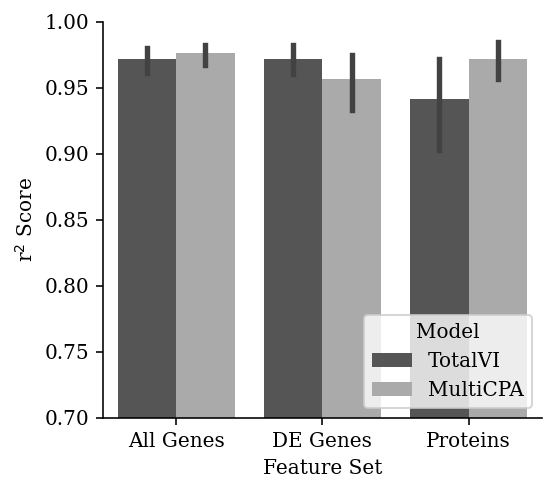

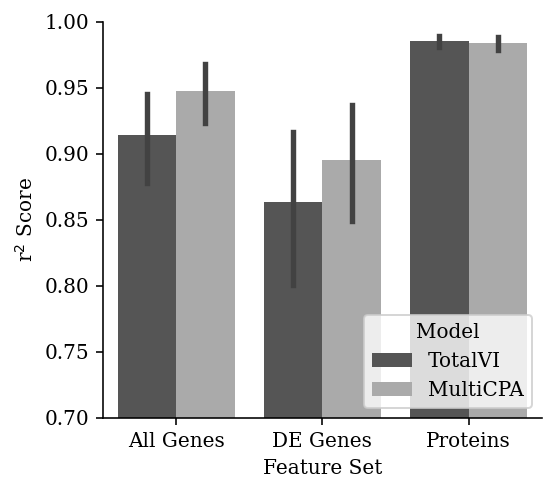

In [61]:
print('test')
for dataset in ['Papalexi2021', 'Wessels2022']:
    with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
    }):
        plt.figure(figsize=(4, 3.5))
        g = sns.barplot(data=df[df['Dataset'] == dataset], y="Score", x="Feature Set", hue="Model", 
                        palette="gray")
        sns.move_legend(g, "lower right")
        plt.ylabel("r$^2$ Score")
        plt.ylim(0.7, 1.0)
        #plt.title(dataset, pad=32)
        plt.tight_layout()
        plt.savefig(f'figures/totalvi_comparison_{dataset}.pdf')

## Baseline Vol 2: How well tolerate Gene removal (after trained)

In [49]:
import logging
logging.getLogger('scvi').setLevel(logging.WARNING)

In [14]:
def delete_percent(percentage_gene, percentage_protein):
    print(f"%{percentage_gene}G%{percentage_protein}P", end=', ')

    adata_raw = model.adata.X.copy()
    adata_raw_obsm = adata_train.obsm['protein_expression'].copy()

    def random_select_gene(gene_array, perc, seed=0):
        np.random.seed(perc + seed)
        a = np.arange(len(gene_array))
        np.random.shuffle(a)
        how_many = int(np.ceil(len(gene_array) / 100 * perc))
        return gene_array[a[:how_many]]

    def random_select_protein(protein_array, perc, seed=0):
        np.random.seed(perc + seed)
        a = np.arange(len(protein_array))
        np.random.shuffle(a)
        how_many = int(np.ceil(len(protein_array) / 100 * perc))
        return protein_array[a[:how_many]]
    
    nt_condition = DATA['nt_condition']
    set_test = set(model.test_indices)

    true_genes = pd.DataFrame(adata_train.X, index=adata_train.obs.index, columns=adata_train.var.index)
    true_proteins = adata_train.obsm['protein_expression'].copy()
    scale_factors = np.array(np.sum(true_genes, axis=1)).ravel()

    test_bools = np.array([i in set_test for i in range(len(adata_train))])
    NT_cells = (adata_train.obs['batch'] == nt_condition) & test_bools
    scale_factors = scale_factors[NT_cells]

    r2genes, r2proteins, r2genes_de = [], [], []
    perts_tot = []

    perts = sorted(np.unique(adata_train.obs["batch"]))
    for ind, perturbation in enumerate(perts):
        #print(f"{ind + 1}/{len(perts)}", end=' ')

        if perturbation != nt_condition:
            ii = adata_train.obs[(adata_train.obs['batch'] == perturbation) & test_bools].index
            if len(ii) > 20:
                perts_tot.append(perturbation)

                #modify adata_train
                #genes_to_process = adata_train.uns["rank_genes_groups_cov"][perturbation]
                genes_to_process = adata_train.var.index
                genes_to_remove = random_select_gene(genes_to_process, percentage_gene)
                model.adata[:, genes_to_remove] = np.zeros((len(adata_train), len(genes_to_remove)))
                
                proteins_to_process = model.adata.obsm["protein_expression"].columns
                proteins_to_remove = random_select_protein(proteins_to_process, percentage_protein)
                model.adata.obsm['protein_expression'].loc[:, proteins_to_remove] = np.zeros_like(model.adata.obsm['protein_expression'].loc[:, proteins_to_remove])

                idx_de = adata_train.var.index.isin(adata_train.uns["rank_genes_groups_cov"][perturbation])

                # get perturbed batch from NT cells
                with contextlib.redirect_stdout(None):
                    gene_means, protein_means = model.get_normalized_expression(
                        indices=NT_cells, 
                        transform_batch=perturbation,
                        include_protein_background=True,
                        sample_protein_mixing=False,
                        return_mean=True,
                        scale_protein=False,
                    )
                gene_means = (gene_means.T * scale_factors).T

                # get true perturbed cells
                ii_p = true_proteins.loc[ii]
                ii_g = true_genes.loc[ii]

                # Get mean value for each gene for a given perturbation
                predicted_genes_mean = gene_means.to_numpy().mean(0)
                predicted_proteins_mean = protein_means.to_numpy().mean(0)
                true_genes_mean = ii_g.to_numpy().mean(0)
                true_proteins_mean = ii_p.to_numpy().mean(0)

                # Calculate r^2 score for both
                r2genes.append(r2_score(predicted_genes_mean, true_genes_mean))
                r2proteins.append(r2_score(predicted_proteins_mean, true_proteins_mean))
                r2genes_de.append(r2_score(predicted_genes_mean[idx_de], true_genes_mean[idx_de]))

                model.adata.X = adata_raw.copy()
                adata_train.obsm['protein_expression'] = adata_raw_obsm.copy()
    del adata_raw, adata_raw_obsm
        
    # For Mulpert
    dataset = cm_datasets["test_treated"]
    genes_control = cm_datasets["test_control"].raw_genes.clone()
    proteins_control = cm_datasets["test_control"].raw_proteins.clone()

    num, dim_genes = genes_control.size(0), genes_control.size(1)
    dim_proteins = proteins_control.size(1)

    genes_control_original = cm_datasets["test_control"].raw_genes.clone()
    proteins_control_original = cm_datasets["test_control"].raw_proteins.clone()

    def random_select_gene(len_gene_array, perc, seed=0):
        np.random.seed(perc + seed)
        a = np.arange(len_gene_array)
        np.random.shuffle(a)
        how_many = int(np.ceil(len_gene_array / 100 * perc))
        return a[:how_many]

    def random_select_protein(len_protein_array, perc, seed=0):
        np.random.seed(perc + seed)
        a = np.arange(len_protein_array)
        np.random.shuffle(a)
        how_many = int(np.ceil(len_protein_array / 100 * perc))
        return a[:how_many]

    mean_score_proteins = []
    mean_score_genes = []
    mean_score_genes_de = []
    perts_mul = []
    for ind, pert_category in enumerate(sorted(np.unique(dataset.pert_categories))):
        de_idx = np.where(dataset.var_names.isin(np.array(dataset.de_genes[pert_category])))[0]
        idx = np.where(dataset.pert_categories == pert_category)[0]
        if len(idx) > 20:

            perts_mul.append(pert_category)
            #print(f"{ind + 1}/{len(np.unique(dataset.pert_categories))}", end=' ')
            emb_drugs = dataset.drugs[idx][0].view(1, -1).repeat(num, 1).clone()
            emb_cts = dataset.cell_types[idx][0].view(1, -1).repeat(num, 1).clone()

            # modify gene_control here
            genes_to_remove = random_select_gene(len(adata.var.index), percentage_gene)
            genes_control_ = genes_control.clone().numpy()
            genes_control_[:, genes_to_remove] = np.zeros((len(genes_control_), len(genes_to_remove)))
            genes_control = torch.Tensor(genes_control_)

            proteins_to_remove = random_select_protein(len(adata.obsm["protein_expression"].columns), percentage_protein)
            proteins_control_ = proteins_control.clone().numpy()
            proteins_control_[:, proteins_to_remove] = np.zeros((len(proteins_control_), len(proteins_to_remove)))
            proteins_control = torch.Tensor(proteins_control_)

            #print(int(genes_control.clone().numpy().sum()))

            gene_predictions, protein_predictions = cm_autoencoder.predict(genes_control, emb_drugs, emb_cts, proteins_control)
            gene_predictions = gene_predictions.detach().cpu()
            protein_predictions = protein_predictions.detach().cpu()

            mean_predict_genes = gene_predictions[:, :dim_genes]
            mean_predict_proteins = protein_predictions[:, :dim_proteins]

            y_true_genes = dataset.raw_genes[idx, :].numpy()
            yt_m_genes = y_true_genes.mean(axis=0)
            yp_m_genes = np.array(mean_predict_genes.mean(0))
            mean_score_genes.append(r2_score(yt_m_genes, yp_m_genes))
            mean_score_genes_de.append(r2_score(yt_m_genes[de_idx], yp_m_genes[de_idx]))

            y_true_proteins = dataset.raw_proteins[idx, :].numpy()
            yt_m_proteins = y_true_proteins.mean(axis=0)
            yp_m_proteins = mean_predict_proteins.mean(0)
            mean_score_proteins.append(r2_score(yt_m_proteins, yp_m_proteins))

            genes_control = genes_control_original.clone()
            proteins_control = proteins_control_original.clone()
    del genes_control_original, proteins_control_original, genes_control, proteins_control     

    perts_mul_filter = [i in perts_tot for i in perts_mul]
    perts_tot_filter = [i in perts_mul for i in perts_tot]
    perts_mul = list(compress(perts_mul, perts_mul_filter))
    perts_tot = list(compress(perts_tot, perts_tot_filter)) 

    r2genes = list(compress(r2genes, perts_tot_filter)) 
    r2genes_de = list(compress(r2genes_de, perts_tot_filter)) 
    r2proteins = list(compress(r2proteins, perts_tot_filter)) 
    mean_score_genes = list(compress(mean_score_genes, perts_mul_filter))
    mean_score_genes_de = list(compress(mean_score_genes_de, perts_mul_filter))
    mean_score_proteins = list(compress(mean_score_proteins, perts_mul_filter))

    df_tot = pd.DataFrame([perts_tot, r2genes, r2genes_de, r2proteins]).T
    df_mul = pd.DataFrame([perts_mul, mean_score_genes, mean_score_genes_de, mean_score_proteins]).T
    df_cols_ = ["Perturbation", "Genes", "DE Genes", "Proteins"]
    df_tot.columns = df_cols_
    df_mul.columns = df_cols_
    df_tot["Model"] = "TotalVI"
    df_mul["Model"] = "MulPert"
    df_all = pd.concat([df_tot, df_mul])
    df_all["Dataset"] = DATA['raw_dir_name']

    df_ = pd.DataFrame()
    for m in ["Genes", "DE Genes", "Proteins"]:
        df_a = df_all[['Perturbation', 'Model', 'Dataset', m]]
        df_a.columns = ['Perturbation', 'Model', 'Dataset', 'Score']
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            df_a['Feature Set'] = m
        df_ = pd.concat([df_, df_a])
    df_all = df_.copy()
    del df_
    df_all.reset_index(inplace=True, drop=True)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        df_all["Genes Removed Percantage"] = percentage_gene
        df_all["Proteins Removed Percantage"] = percentage_protein
    #torch.cuda.empty_cache()
    #torch.clear_autocast_cache()
    
    return df_all
print('ok')

ok


In [ ]:
# Run Papalexi First
if DATA['raw_dir_name'] == 'Papalexi2021':
    df_del = pd.DataFrame()
else:
    df_del = pd.read_pickle(f"/home/icb/kemal.inecik/work/mulpert_totalvi_vs_mulpert_remove_percentages_papalexi_df.pk")

for i_del in list(range(0, 110, 10)):
    for j_del in list(range(0, 110, 10)):
        df_del_p = delete_percent(i_del, j_del)
        df_del = pd.concat([df_del, df_del_p])
df_del.reset_index(inplace=True, drop=True)
df_del.to_pickle(f"/home/icb/kemal.inecik/work/mulpert_totalvi_vs_mulpert_remove_percentages_df.pk")

In [15]:
df_del = pd.read_pickle(f"/home/icb/kemal.inecik/work/mulpert_totalvi_vs_mulpert_remove_percentages_df.pk")

In [16]:
df_del

,Perturbation,Model,Dataset,Score,Feature Set,Genes Removed Percantage,Proteins Removed Percantage
0,THP-1_ATF2_1.0,TotalVI,Papalexi2021,0.991797,Genes,0,0
1,THP-1_BRD4_1.0,TotalVI,Papalexi2021,0.959766,Genes,0,0
2,THP-1_CAV1_1.0,TotalVI,Papalexi2021,0.986483,Genes,0,0
3,THP-1_CD86_1.0,TotalVI,Papalexi2021,0.98844,Genes,0,0
4,THP-1_CMTM6_1.0,TotalVI,Papalexi2021,0.990815,Genes,0,0
...,...,...,...,...,...,...,...
45733,THP-1_MED22+MED24_1+1,MulPert,Wessel2022,0.94638,Proteins,100,100
45734,THP-1_MED24+SMARCD1_1+1,MulPert,Wessel2022,0.988121,Proteins,100,100
45735,THP-1_MED24+VPRBP_1+1,MulPert,Wessel2022,0.991937,Proteins,100,100
45736,THP-1_SUPT16H+SUPT5H_1+1,MulPert,Wessel2022,0.961626,Proteins,100,100


<AxesSubplot:xlabel='Genes Removed Percantage', ylabel='Score'>

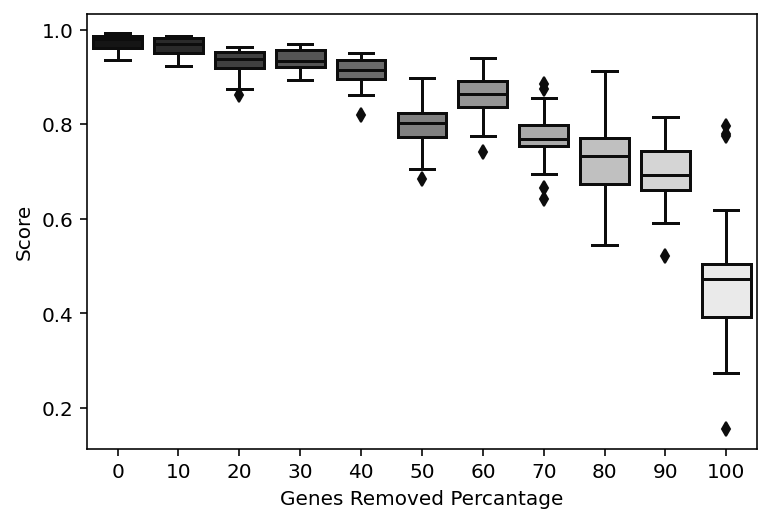

In [30]:
sns.boxplot(data=df_del[(df_del["Model"] == "TotalVI") & 
                        (df_del["Dataset"] == "Papalexi2021") & 
                       (df_del["Feature Set"] == "Genes") & 
                           (df_del["Proteins Removed Percantage"] == 0)], 
            x="Genes Removed Percantage", y="Score", palette='gray')

<AxesSubplot:xlabel='Genes Removed Percantage', ylabel='Score'>

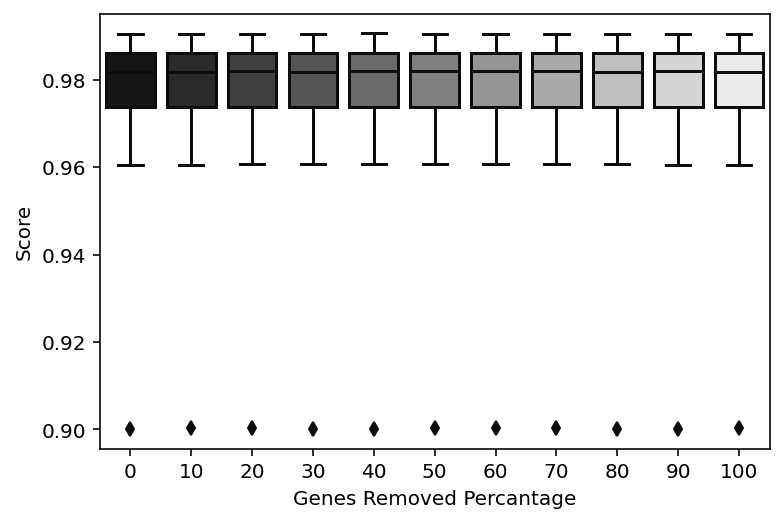

In [32]:
sns.boxplot(data=df_del[(df_del["Model"] == "MulPert") & 
                        (df_del["Dataset"] == "Papalexi2021") & 
                       (df_del["Feature Set"] == "Genes") & 
                           (df_del["Proteins Removed Percantage"] == 0)], 
            x="Genes Removed Percantage", y="Score", palette='gray')

<AxesSubplot:xlabel='Proteins Removed Percantage', ylabel='Score'>

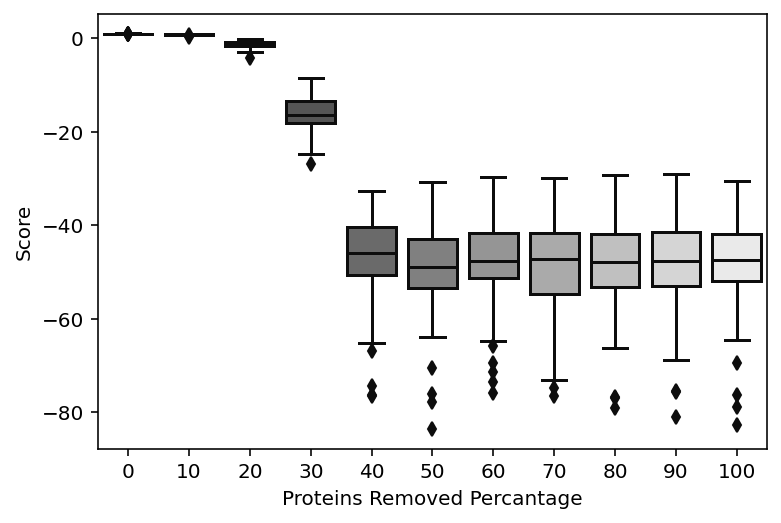

In [34]:
sns.boxplot(data=df_del[(df_del["Model"] == "TotalVI") & 
                        (df_del["Dataset"] == "Wessel2022") & 
                       (df_del["Feature Set"] == "Proteins") & 
                           (df_del["Genes Removed Percantage"] == 0)], 
            x="Proteins Removed Percantage", y="Score", palette='gray')

<AxesSubplot:xlabel='Proteins Removed Percantage', ylabel='Score'>

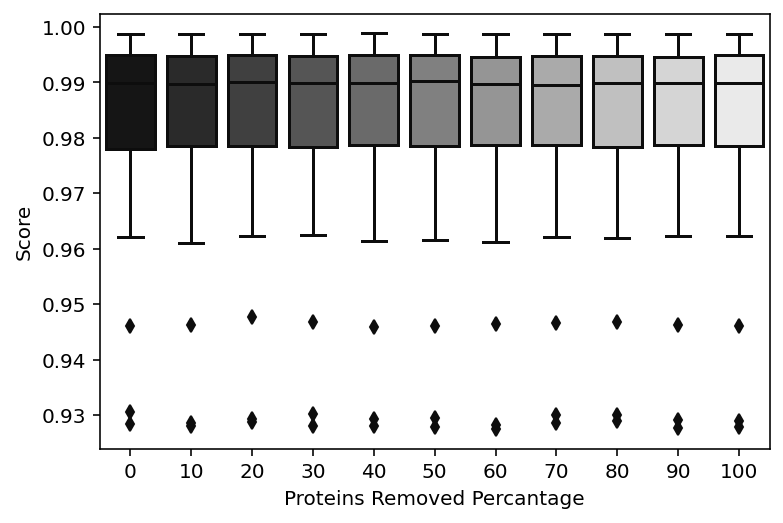

In [35]:
sns.boxplot(data=df_del[(df_del["Model"] == "MulPert") & 
                        (df_del["Dataset"] == "Wessel2022") & 
                       (df_del["Feature Set"] == "Proteins") & 
                           (df_del["Genes Removed Percantage"] == 0)], 
            x="Proteins Removed Percantage", y="Score", palette='gray')

In [12]:
# create modified adata removed X percent of the genes.
# do the same above:
    # check how well it tolarates
# do this using the mulpert model.

In [14]:
# the same for protein entries

## Baseline Vol 3: How well tolerate Gene removal (PAPALEXI - Wessel)

In [9]:
# train TotalVI with 25% gene and 25% protein deleted
# for five perturbations

In [49]:
PERCENTS = [20, 40, 60, 80]

In [50]:
for dataset in ['papalexi', 'wessel_ood']:
    DATA = DATAM[dataset]

    if False:

        for PERCENT in PERCENTS:

            np.random.seed(42)
            raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
            adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))
            remove_number_of_perturbation = int(np.floor(len(np.unique(adata.obs['cov_drug_dose_name'])) / 4))
            random_perturbations = np.random.choice(np.unique(adata.obs['cov_drug_dose_name']), remove_number_of_perturbation, replace=False)

            for i in range(len(random_perturbations)):

                np.random.seed(42 + i + PERCENT)
                random_genes = np.random.choice(list(range(len(adata.var.index))), int(np.ceil(len(adata.var.index) * PERCENT / 100)), replace=False)
                random_proteins = np.random.choice(list(range(len(adata.uns['protein_names']))), int(np.ceil(len(adata.uns['protein_names']) * PERCENT / 100)), replace=False)
                row_index = np.array(list(range(len(adata))))[adata.obs['cov_drug_dose_name'] == random_perturbations[i]]

                k = pd.DataFrame(adata.X.A)
                k.loc[row_index, random_genes] = 0
                adata.X = csr_matrix(np.array(k))

                k = pd.DataFrame(adata.layers['counts'].A)
                k.loc[row_index, random_genes] = 0
                adata.layers['counts'] = csr_matrix(k)

                k = pd.DataFrame(adata.obsm['protein_expression'])
                k.loc[row_index, random_proteins] = 0
                adata.obsm['protein_expression'] = np.array(k)

                k = pd.DataFrame(adata.obsm['protein_expression_raw'])
                k.loc[row_index, random_proteins] = 0
                adata.obsm['protein_expression_raw'] = np.array(k)

            # save as different name
            adata.write(f"/home/icb/kemal.inecik/work/codes/mulpert/datasets/modified_{PERCENT}_{DATA['adata_name']}")


In [51]:
for dataset in ['papalexi', 'wessel_ood']:
    DATA = DATAM[dataset]
    
    for PERCENT in PERCENTS:
        if False:
            adata = sc.read(f"/home/icb/kemal.inecik/work/codes/mulpert/datasets/modified_{PERCENT}_{DATA['adata_name']}")

            adata.X = adata.layers['counts'].copy()
            adata.obsm["protein_expression"] = adata.obsm["protein_expression_raw"].copy()
            del adata.layers['counts']
            del adata.obsm["protein_expression_raw"]

            adata.obsm['protein_expression'] = pd.DataFrame(adata.obsm['protein_expression'].astype(int), index=adata.obs.index, columns=adata.uns['protein_names'])
            adata.X = adata.X.A.astype(int)
            de_genes = adata.uns["rank_genes_groups_cov"].copy()
            del adata.uns
            del adata.var
            adata.obs = adata.obs[['cov_drug_dose_name', 'control', 'split']]
            adata.obs.columns = ['batch', 'control', 'split']
            adata.uns["rank_genes_groups_cov"] = de_genes

            scvi.model.TOTALVI.setup_anndata(adata, batch_key="batch", protein_expression_obsm_key="protein_expression")
            model = scvi.model.TOTALVI(adata)
            # as the Papalexi split is 0.85 to 0.15
            model.train(train_size=0.75, validation_size = 0.10, max_epochs=300)

            plt.plot(model.history["elbo_train"], label="train")
            plt.plot(model.history["elbo_validation"], label="val")
            plt.title("Negative ELBO over training epochs")
            plt.legend(); plt.show()

            with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_percent{PERCENT}_model.pt", 'wb') as f1:
                pickle.dump(model, f1)
            with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_percent{PERCENT}_adata.pt", 'wb') as f2:
                pickle.dump(adata, f2)

In [18]:
result_deleted = dict()
result_deleted["TotalVI"] = dict()

for dataset in ['wessel_ood', 'papalexi']:
    DATA = DATAM[dataset]
    result_deleted["TotalVI"][dataset] = dict()
    
    for PERCENT in PERCENTS:
        
        result_deleted["TotalVI"][dataset][PERCENT] = dict()

        with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_percent{PERCENT}_model.pt", 'rb') as f1:
            model = pickle.load(f1)
        with open(f"pretrained_models/TotalVI_{DATA['raw_dir_name']}_percent{PERCENT}_adata.pt", 'rb') as f2:
            adata_train = pickle.load(f2)
        
        raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
        adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))
        
        np.random.seed(42)
        remove_number_of_perturbation = int(np.floor(len(np.unique(adata_train.obs['batch'])) / 4))
        random_perturbations = np.random.choice(np.unique(adata_train.obs['batch']), remove_number_of_perturbation, replace=False)

        nt_condition = DATA['nt_condition']
        set_test = set(model.test_indices)

        true_genes = pd.DataFrame(adata.layers["counts"].A, index=adata.obs.index, columns=adata.var.index)
        true_proteins = pd.DataFrame(adata.obsm['protein_expression_raw'].copy(), index=adata.obs.index, columns=adata.uns["protein_names"])

        true_genes_percent = pd.DataFrame(adata_train.X, index=adata_train.obs.index, columns=adata_train.var.index)
        scale_factors = np.array(np.sum(true_genes_percent, axis=1)).ravel()

        test_bools = np.array([i in set_test for i in range(len(adata))])
        NT_cells = (adata_train.obs['batch'] == nt_condition) & test_bools
        scale_factors = scale_factors[NT_cells]

        all_perts = sorted(np.unique(adata_train.obs["batch"]))
        for perturb_class, perts in zip(['all_perturbations', 'deleted_perturbations'], [all_perts, random_perturbations]):
            
            r2genes, r2proteins, r2genes_de, perts_tot = [], [], [], []
            
            for ind, perturbation in enumerate(perts):
                #print(f"{ind + 1}/{len(perts)}", end=' ')

                if perturbation != nt_condition:
                    ii = adata_train.obs[(adata_train.obs['batch'] == perturbation) & test_bools].index
                    if len(ii) > 20:
                        perts_tot.append(perturbation)
                        idx_de = adata_train.var.index.isin(adata_train.uns["rank_genes_groups_cov"][perturbation])

                        # get perturbed batch from NT cells
                        gene_means, protein_means = model.get_normalized_expression(
                            indices=NT_cells, 
                            transform_batch=perturbation,
                            include_protein_background=True,
                            sample_protein_mixing=False,
                            return_mean=True,
                            scale_protein=False,
                        )
                        gene_means = (gene_means.T * scale_factors).T

                        # get true perturbed cells
                        ii_p = true_proteins.loc[ii]
                        ii_g = true_genes.loc[ii]

                        # Get mean value for each gene for a given perturbation
                        predicted_genes_mean = gene_means.to_numpy().mean(0)
                        predicted_proteins_mean = protein_means.to_numpy().mean(0)
                        true_genes_mean = ii_g.to_numpy().mean(0)
                        true_proteins_mean = ii_p.to_numpy().mean(0)

                        # Calculate r^2 score for both
                        r2genes.append(r2_score(predicted_genes_mean, true_genes_mean))
                        r2proteins.append(r2_score(predicted_proteins_mean, true_proteins_mean))
                        r2genes_de.append(r2_score(predicted_genes_mean[idx_de], true_genes_mean[idx_de]))
            result_deleted["TotalVI"][dataset][PERCENT][perturb_class] = {
                "r2_genes": r2genes,
                "r2_genes_de": r2genes_de,
                "r2_proteins": r2proteins,
                "perturbation": perts_tot
            }


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       
INFO     Input AnnData not setup with scvi-tools. attempting

`train models with mpert19s`

In [19]:
result_deleted["MulPert"] = dict()

for dataset_n in ['papalexi', 'wessel_ood']:
    
    raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
    adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))
    
    DATA = DATAM[dataset_n]
    result_deleted["MulPert"][dataset_n] = dict()
    #######################
    mulpert_models = pd.read_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/{DATA['seml']}_pickled.pk")
    spt = 'test'
    focus_metric_1 = f"{spt}_mean_score_genes_last"
    focus_metric_2 = f"{spt}_mean_score_proteins_last"

    mulpert_models = mulpert_models[(mulpert_models['status'] == 1)]
    mulpert_models = mulpert_models[(mulpert_models[focus_metric_1] > 0) & (mulpert_models[focus_metric_2] > 0)]
    mulpert_models["overall_best"] = np.sqrt(mulpert_models[focus_metric_1]**2 + mulpert_models[focus_metric_2]**2)

    top_top = 5
    mulpert_models = mulpert_models.sort_values(by=["overall_best"], ascending=False)[:top_top]
    
    chosen_model = mulpert_models.index[0]

    chosen_model_entry = mulpert_models.loc[chosen_model]
    _, cm_datasets, _, _, cm_hypers = \
        model_importer(chosen_model, mulpert_models, 
                       model_dir=f"/storage/groups/ml01/workspace/kemal.inecik/seml/{DATA['seml']}/_last/", 
                       #model_dir=f"/home/icb/kemal.inecik/work/codes/mulpert/seml/_last/", 
                       dataset_relative_to="/home/icb/kemal.inecik/work/codes/mulpert")
    assert cm_hypers['hparams']['adversary_wd'] == mulpert_models.loc[chosen_model]['config.model.model_args.hparams.adversary_wd']
    
    #######################
    mulpert_models = pd.read_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/mpert19/mpert19_pickled.pk")
    spt = 'test'
    focus_metric_1 = f"{spt}_mean_score_genes_last"
    focus_metric_2 = f"{spt}_mean_score_proteins_last"

    mulpert_models["overall_best"] = np.sqrt(mulpert_models[focus_metric_1]**2 + mulpert_models[focus_metric_2]**2)
    m = [i.split('/')[1].split('_')[1:3] for i in mulpert_models["config.dataset.dataset_args.dataset_path"]]
    m_dict = {"Papalexi21": "papalexi", "Wessel22": "wessel_ood"}
    m = [[int(i), m_dict[j]] for i, j in m]
    mulpert_models = pd.concat([mulpert_models, pd.DataFrame(m, columns=["PERCENT", 'dataset_n'], index=mulpert_models.index)], axis=1)

    mulpert_models = mulpert_models.sort_values(by=["overall_best"], ascending=False)
    #######################
    print(dataset_n)
    
    for PERCENT in PERCENTS:
        
        result_deleted["MulPert"][dataset_n][PERCENT] = dict()
    
        narr_df_ = mulpert_models[(mulpert_models["PERCENT"] == PERCENT) & (mulpert_models["dataset_n"] == dataset_n)].index
        assert len(narr_df_) == 1
        chosen_model = narr_df_[0]
        try:
            mul_autoencoder, mul_datasets, mul_state, mul_history, mul_hypers = \
                model_importer(chosen_model, mulpert_models, 
                               model_dir=f"/storage/groups/ml01/workspace/kemal.inecik/seml/mpert19/_last/", 
                               #model_dir=f"/home/icb/kemal.inecik/work/codes/mulpert/seml/_last/", 
                               dataset_relative_to="/home/icb/kemal.inecik/work/codes/mulpert")
            assert mul_hypers['hparams']['adversary_wd'] == mulpert_models.loc[chosen_model]['config.model.model_args.hparams.adversary_wd']
        except NotImplementedError:
            continue
        
        
        
        dataset = cm_datasets["test_treated"]
        genes_control = mul_datasets["test_control"].raw_genes
        proteins_control = mul_datasets["test_control"].raw_proteins
        num, dim_genes = genes_control.size(0), genes_control.size(1)
        dim_proteins = proteins_control.size(1)
        #assert np.all(mul_datasets["test_control"].var_names == adata.var.index) # for mm consistency

        
        raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
        adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))
        np.random.seed(42)
        remove_number_of_perturbation = int(np.floor(len(np.unique(adata.obs['cov_drug_dose_name'])) / 4))
        random_perturbations = np.random.choice(np.unique(adata.obs['cov_drug_dose_name']), remove_number_of_perturbation, replace=False)

        all_perts = sorted(np.unique(adata.obs["cov_drug_dose_name"]))
        for perturb_class, perts in zip(['all_perturbations', 'deleted_perturbations'], [all_perts, random_perturbations]):
            
            mean_score_proteins = []
            mean_score_genes = []
            mean_score_genes_de = []
            perts_mul = []
        
            for pert_category in sorted(np.unique(dataset.pert_categories)):
                de_idx = np.where(dataset.var_names.isin(np.array(dataset.de_genes[pert_category])))[0]
                idx = np.where(dataset.pert_categories == pert_category)[0]

                if len(idx) > 20:
                    perts_mul.append(pert_category)

                    emb_drugs = dataset.drugs[idx][0].view(1, -1).repeat(num, 1).clone()
                    emb_cts = dataset.cell_types[idx][0].view(1, -1).repeat(num, 1).clone()

                    gene_predictions, protein_predictions = mul_autoencoder.predict(genes_control, emb_drugs, emb_cts, proteins_control)
                    gene_predictions = gene_predictions.detach().cpu()
                    protein_predictions = protein_predictions.detach().cpu()

                    mean_predict_genes = gene_predictions[:, :dim_genes]
                    mean_predict_proteins = protein_predictions[:, :dim_proteins]

                    y_true_genes = dataset.raw_genes[idx, :].numpy()
                    yt_m_genes = y_true_genes.mean(axis=0)
                    yp_m_genes = np.array(mean_predict_genes.mean(0))
                    mean_score_genes.append(r2_score(yt_m_genes, yp_m_genes))
                    mean_score_genes_de.append(r2_score(yt_m_genes[de_idx], yp_m_genes[de_idx]))

                    y_true_proteins = dataset.raw_proteins[idx, :].numpy()
                    yt_m_proteins = y_true_proteins.mean(axis=0)
                    yp_m_proteins = mean_predict_proteins.mean(0)
                    mean_score_proteins.append(r2_score(yt_m_proteins, yp_m_proteins))
            
            result_deleted["MulPert"][dataset_n][PERCENT][perturb_class] = {
                "r2_genes": mean_score_genes,
                "r2_genes_de": mean_score_genes_de,
                "r2_proteins": mean_score_proteins,
                "perturbation": perts_mul
            }

        print(PERCENT)

papalexi
20
80
wessel_ood
20
40
60
80


In [20]:
nm = pd.DataFrame()
for m1 in ['TotalVI', 'MulPert']:
    for m2 in ['wessel_ood', 'papalexi']:
        for m3 in PERCENTS:
            for m4 in ['all_perturbations', 'deleted_perturbations']:
                try:
                    n = pd.DataFrame.from_dict(result_deleted[m1][m2][m3][m4])
                    n['perturb_class'] = m4
                    n['percent'] = m3
                    n['dataset'] = m2
                    n['model'] = m1
                    nm = pd.concat([nm, n])
                except KeyError:
                    pass 

In [21]:
nmc = pd.DataFrame()
for m in 'r2_genes', 'r2_genes_de', 'r2_proteins':
    nmc_ = pd.concat([nm[['perturbation', 'perturb_class', 'percent', 'dataset', 'model']], nm[m]], axis=1)
    nmc_.columns = ['perturbation', 'perturb_class', 'percent', 'dataset', 'model', 'score']
    nmc_['feature set'] = m
    nmc = pd.concat([nmc, nmc_])

In [22]:
nmc.to_pickle('notebooks/totalvi_DELETE_ME.pk')

In [52]:
nmc = pd.read_pickle('notebooks/totalvi_DELETE_ME.pk')

In [53]:
x__label = "Removed Feature Percentage"
nmc.columns = ['Perturbation', 'perturb_class', x__label, 'Dataset', 'Model', 'Score', 'Feature Set']
nmc['Feature Set'] = nmc['Feature Set'].replace({'r2_genes': 'All Genes', 'r2_genes_de': 'DE Genes', 'r2_proteins': 'Proteins'})
nmc['Model'] = nmc['Model'].replace({'MulPert':'MultiCPA'})

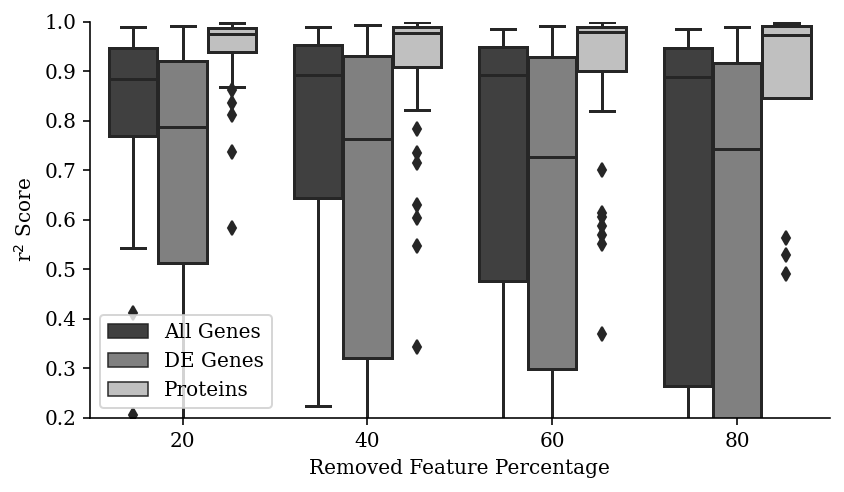

In [54]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(6, 3.5))
    g = sns.boxplot(data=nmc[(nmc["perturb_class"] == "all_perturbations") & 
                        (nmc["Dataset"] == "wessel_ood") & 
                        (nmc["Model"] == "TotalVI") &  (nmc[x__label].isin([20, 40, 60, 80]))
                        ], 
                x=x__label, y='Score', hue='Feature Set', palette='gray')
    #plt.title("TotalVI")
    g.legend(loc='lower left')
    plt.ylim(0.2, 1)
    plt.ylabel("r$^2$ Score")
    plt.tight_layout()
    plt.savefig(f"figures/removed_percentage_{'wessel_ood'}_{'TotalVI'}.pdf")

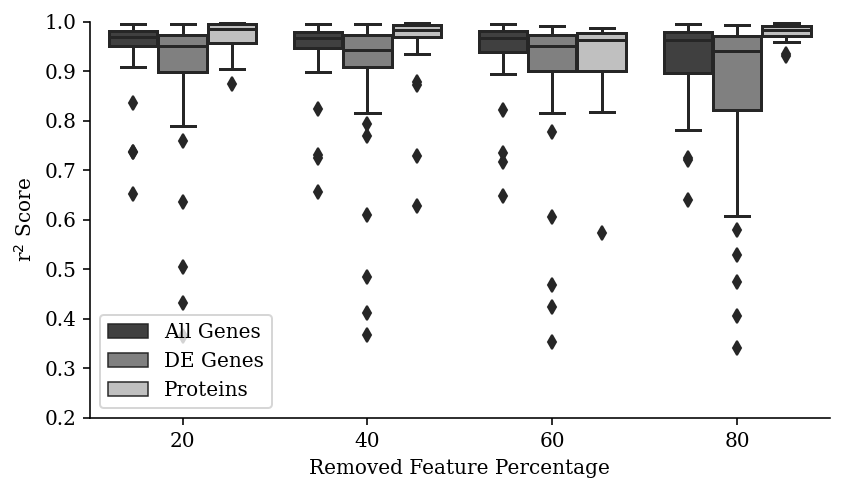

In [55]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(6, 3.5))
    g = sns.boxplot(data=nmc[(nmc["perturb_class"] == "all_perturbations") & 
                        (nmc["Dataset"] == "wessel_ood") & 
                        (nmc["Model"] == "MultiCPA") &  (nmc[x__label].isin([20, 40, 60, 80]))
                        ], 
                x=x__label, y='Score', hue='Feature Set', palette='gray')
    #plt.title("TotalVI")
    g.legend(loc='lower left')
    plt.ylim(0.2, 1)
    plt.ylabel("r$^2$ Score")
    plt.tight_layout()
    plt.savefig(f"figures/removed_percentage_{'wessel_ood'}_{'MultiCPA'}.pdf")

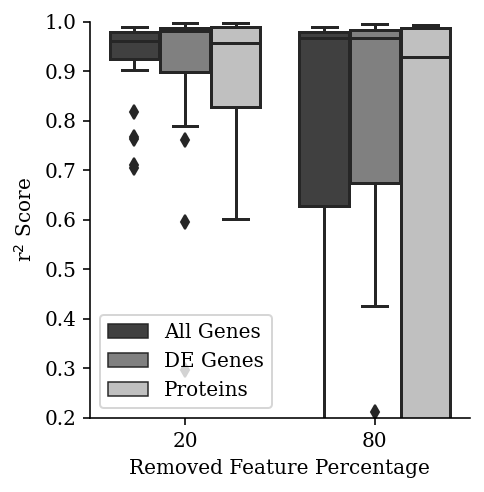

In [56]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(3.5, 3.5))
    g = sns.boxplot(data=nmc[(nmc["perturb_class"] == "all_perturbations") & 
                        (nmc["Dataset"] == "papalexi") & 
                        (nmc["Model"] == "TotalVI") &  (nmc[x__label].isin([20, 80]))
                        ], 
                x=x__label, y='Score', hue='Feature Set', palette='gray')
    #plt.title("TotalVI")
    g.legend(loc='lower left')
    plt.ylim(0.2, 1)
    plt.ylabel("r$^2$ Score")
    plt.tight_layout()
    plt.savefig(f"figures/removed_percentage_{'papalexi'}_{'TotalVI'}.pdf")

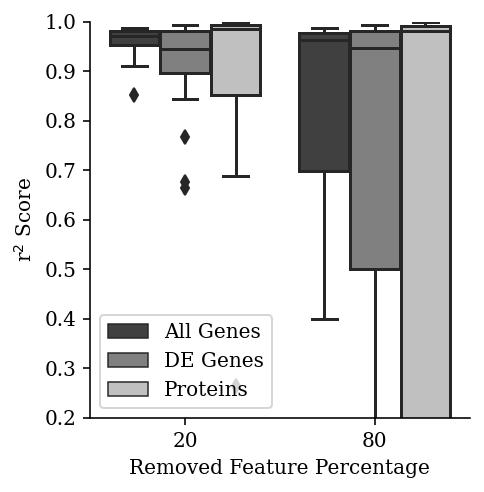

In [57]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(3.5, 3.5))
    g = sns.boxplot(data=nmc[(nmc["perturb_class"] == "all_perturbations") & 
                        (nmc["Dataset"] == "papalexi") & 
                        (nmc["Model"] == "MultiCPA") &  (nmc[x__label].isin([20, 80]))
                        ], 
                x=x__label, y='Score', hue='Feature Set', palette='gray')
    #plt.title("TotalVI")
    g.legend(loc='lower left')
    plt.ylim(0.2, 1)
    plt.ylabel("r$^2$ Score")
    plt.tight_layout()
    plt.savefig(f"figures/removed_percentage_{'papalexi'}_{'MultiCPA'}.pdf")

## Baseline Vol 4: Expected R2



In [130]:
#100 times from all cells in c1-c3 (every time I will shuffle. in the first time c4 is out then c1 etc),

#choose random number of cells from c1-c3 (let's say %25-%35 etc).

#get the mean gene and mean protein from selected cells.

#get the mean gene and mean protein from all cells in c4.

#compute r2 for Genes, DEG, Proteins.

In [ ]:
base_truth = dict()
for dataset in ['papalexi', 'wessel_ood']:
    DATA = DATAM[dataset]

    raw_data_dir = f"/storage/groups/ml01/workspace/kemal.inecik/{DATA['raw_dir_name']}"
    adata = sc.read(os.path.join(raw_data_dir, DATA['adata_name']))

    adata.X = adata.layers['counts'].copy()
    adata.obsm["protein_expression"] = adata.obsm["protein_expression_raw"].copy()
    del adata.layers['counts']
    del adata.obsm["protein_expression_raw"]

    adata.obsm['protein_expression'] = pd.DataFrame(adata.obsm['protein_expression'].astype(int), index=adata.obs.index, columns=adata.uns['protein_names'])
    adata.X = adata.X.A.astype(int)
    de_genes = adata.uns["rank_genes_groups_cov"].copy()
    del adata.uns
    del adata.var
    adata.obs = adata.obs[['cov_drug_dose_name', 'control', 'split']]
    adata.obs.columns = ['batch', 'control', 'split']
    adata.uns["rank_genes_groups_cov"] = de_genes
    adata = adata[adata.obs['split'] == 'test']
    adata

    print(dataset)
    all_genes = []
    de_genes = []
    proteins = []
    for ind in range(10000):
        
        print('.', end='')
        np.random.seed(0 + ind)
        batch_to_predict = np.random.choice(sorted(np.unique(adata.obs['batch'])))
        percent_genes_proteins = np.random.randint(10, 90)
        
        if batch_to_predict != DATA['nt_condition']:
            de_batch = adata.var.index.isin(adata.uns['rank_genes_groups_cov'][batch_to_predict])
            genes_data = adata[adata.obs['batch'] == batch_to_predict].X
            percent_cell = int(np.ceil(len(genes_data) * percent_genes_proteins / 100))
            keep_cell = np.random.choice(len(genes_data), percent_cell, replace=False)
            genes_data = genes_data[keep_cell, :]
            
            protein_data = np.array(adata[adata.obs['batch'] == batch_to_predict].obsm['protein_expression'])
            protein_data = protein_data[keep_cell, :]
                                    
            true_genes = np.mean(genes_data, axis=0)
            true_genes_de = true_genes[de_batch]
            true_proteins = np.mean(protein_data, axis=0)

            predicted_genes = np.mean(adata[adata.obs['batch'] != batch_to_predict].X, axis=0)
            predicted_genes_de = predicted_genes[de_batch]
            predicted_proteins = np.mean(np.array(adata[adata.obs['batch'] != batch_to_predict].obsm['protein_expression']), axis=0)

            all_genes.append(r2_score(true_genes, predicted_genes))
            de_genes.append(r2_score(true_genes_de, predicted_genes_de))
            proteins.append(r2_score(true_proteins, predicted_proteins))
    base_truth[dataset] = [all_genes, de_genes, proteins]
    print()

In [62]:
if False:
    with open(f"notebooks/base_truth_DELETE_ME.pk", 'wb') as f1:
        pickle.dump(base_truth, f1)
else:
    with open(f"notebooks/base_truth_DELETE_ME.pk", 'rb') as f1:
        base_truth = pickle.load(f1)

In [63]:
dataset = 'wessel_ood'

In [64]:
np.mean(base_truth[dataset][0]), np.mean(base_truth[dataset][1]), np.mean(base_truth[dataset][2]) 

(0.7167251358529619, -0.33044499267756605, 0.8722047786451917)

In [65]:
np.std(base_truth[dataset][0]), np.std(base_truth[dataset][1]), np.std(base_truth[dataset][2]) 

(0.3139764777041594, 14.426886861412303, 0.4198704212784044)

In [66]:
dataset = 'papalexi'

In [67]:
np.mean(base_truth[dataset][0]), np.mean(base_truth[dataset][1]), np.mean(base_truth[dataset][2]) 

(0.8795488752880246, -0.019253170469792896, 0.027211267138113004)

In [68]:
np.std(base_truth[dataset][0]), np.std(base_truth[dataset][1]), np.std(base_truth[dataset][2]) 

(0.13865411885630508, 4.8724202481360575, 2.3634924419432943)

In [69]:
am = pd.DataFrame()
for dataset in ['papalexi', 'wessel_ood']:
    for ind, feature in enumerate(['All Genes', 'DE Genes', 'Proteins']):
        a = pd.DataFrame(base_truth[dataset][ind])
        a.columns = ['Score']
        a["Dataset"] = dataset
        a["Feature Set"] = feature
        am = pd.concat([am, a])
am["Dataset"] = am["Dataset"].replace({'papalexi':'Papalexi2021', 'wessel_ood':'Wessels2022'})

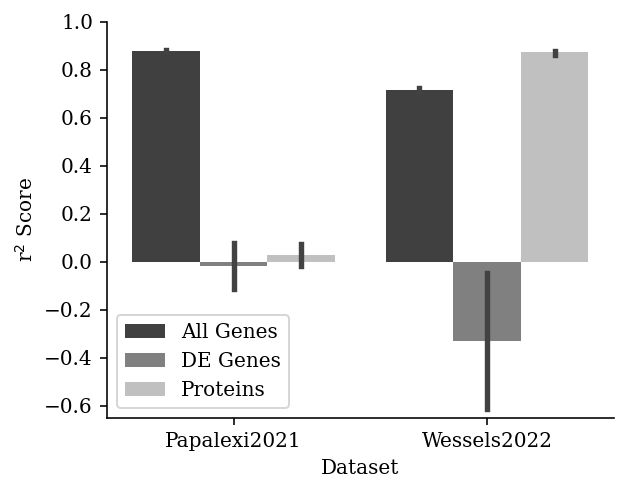

In [70]:
with plt.rc_context({
    "axes.spines.right": False,
    "axes.spines.top": False,
}):
    plt.figure(figsize=(4.5, 3.5))
    g = sns.barplot(data=am, 
                x="Dataset", y='Score', hue='Feature Set', palette='gray')
    #plt.title("TotalVI")
    g.legend(loc='lower left')
    plt.ylim(-0.65, 1)
    plt.ylabel("r$^2$ Score")
    plt.tight_layout()
    plt.savefig(f"figures/baseline_datasets.pdf")